In [24]:
import pennylane as qml
import pennylane.numpy as np
import scipy.io.wavfile
import wave
import time
import math
import matplotlib.pyplot as plt

In [134]:


# Function to load a WAV file
def load_wav(filename):
    sample_rate, data = scipy.io.wavfile.read(filename)
    # If stereo, convert to mono by averaging the two channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    return sample_rate, data

# Function to save a WAV file
def save_wav(filename, sample_rate, data):
    scipy.io.wavfile.write(filename, sample_rate, data)

# Function to convert audio samples to 8-bit
def convert_to_8bit(data):
    # Normalize data to the range of 8-bit audio [-128, 127]
    data = ((data - data.min()) / (data.max() - data.min()) * 255 - 128).astype(np.int8)
    return data

filename = 'qhack_demo6_short.wav'  # Specify your input file name here
sample_rate, original_data = load_wav(filename)

print("done converting wav data")

def QPAM_Encoding_Normalization(samples):
    # Normalize the array to be between 0 and 2
    normalized_arr = 2 * (samples - np.min(samples)) / (np.max(samples) - np.min(samples))

    # 2301.01595.pdf
    # • Step 1: add 1 to all amplitudes an
    # • Step 2: divide the amplitudes by 2
    # • Step 3: divide again, by the sum of all of the amplitudes
    # • Step 4: take the square root of the result

    np_data = np.array(normalized_arr)
    np_data += 1
    np_data /= 2
    sum = np.sum(np_data)
    np_data = np_data/sum

    print(np_data)
    return np_data

features = QPAM_Encoding_Normalization(original_data)
length = features.shape[0]
nb_qubits = math.ceil(np.log2(length))


print(f"number of qubits used for encoding: {nb_qubits}")


done converting wav data
[8.93337327e-05 8.93348388e-05 8.93522803e-05 ... 6.63315081e-05
 6.49206175e-05 6.35436529e-05]
number of qubits used for encoding: 14


C:\Users\simon\AppData\Local\Temp\ipykernel_28716\2015458246.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = scipy.io.wavfile.read(filename)


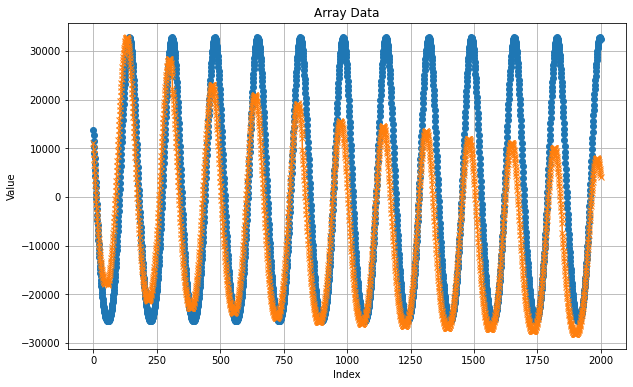

In [135]:
dev = qml.device('default.qubit', wires=nb_qubits)


# Prepare your carrier wave (simplified example)
carrier_frequency = 0.1 # Low frequency
time = np.linspace(0, 1, len(features)) # Assuming 'features' is your audio signal array
sine = np.sin(2 * np.pi * carrier_frequency * time)

@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)

    return qml.probs(wires=range(nb_qubits))

@qml.qnode(dev)
def circuit2(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)

    qml.QFT(wires=range(nb_qubits))

    for i in range(nb_qubits):
        qml.PhaseShift(0.1, wires=i)

    qml.adjoint(qml.QFT)(wires=range(nb_qubits))

    return qml.probs(wires=range(nb_qubits))

results = circuit(features)
results = results[200:-200]
results2 = circuit2(features)
results2 = results2[200:-200]
#print(f"encoding result: {results}")
normalized_results = ((results - np.min(results)) / (np.max(results) - np.min(results))) * (32767 + 32768) - 32768
normalized_results2 = ((results2 - np.min(results2)) / (np.max(results2) - np.min(results2))) * (32767 + 32768) - 32768

# Create a graph to display the data
plt.figure(figsize=(10, 6))
plt.plot(normalized_results[0:2000], marker='o')
plt.plot(normalized_results2[0:2000], marker='x')
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

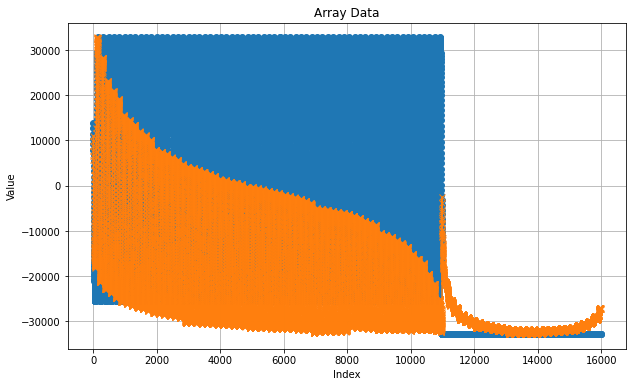

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_results, marker='o')
plt.plot(normalized_results2, marker='x')
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [140]:
import time

# Create a WAV file
with wave.open(f'mega{time.time()}.wav', 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    quantum_samples_array = np.array(normalized_results2, dtype=np.int16)
    print(quantum_samples_array)
    wav_file.writeframes(np.array(quantum_samples_array).tobytes())

print(f"mega{time.time()}.wav file has been created.")

[ 11011   9919   8825 ... -27131 -27146 -27165]
mega1707504819.232947.wav file has been created.


encoding result: [0.00011537 0.00011537 0.00011538 ... 0.         0.         0.        ]
[ -3641  -3641  -3638 ... -32768 -32768 -32768]
mega1707499109.82974.wav file has been created.


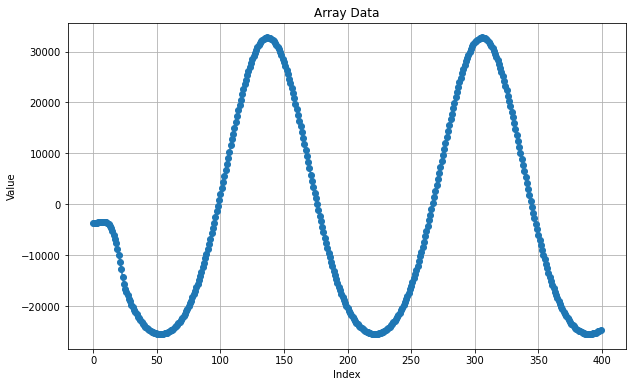

In [39]:
dev = qml.device('default.qubit', wires=nb_qubits)


@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)

    return qml.probs(wires=range(nb_qubits))


results = circuit(features)
print(f"encoding result: {results}")
normalized_results = ((results - np.min(results)) / (np.max(results) - np.min(results))) * (32767 + 32768) - 32768

# Create a graph to display the data
plt.figure(figsize=(10, 6))
plt.plot(normalized_results[0:400], marker='o')
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()